## Computer Vision

1. Face Recognition:
Use CV to recognize faces for user's logins validation.

2. Image Similarity Search:
Use CV to search images with other image as query and find similar images.

## Face Recognition

In [21]:
from facenet_pytorch import InceptionResnetV1
import torch
import PIL
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mtcnn import MTCNN
from utils.computer_vision import FaceDataset, plot_images_horizontal
from torch.utils.data import DataLoader
from qdrant_client import QdrantClient
from qdrant_client.http import models

GPU agnostic

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device 

'cpu'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


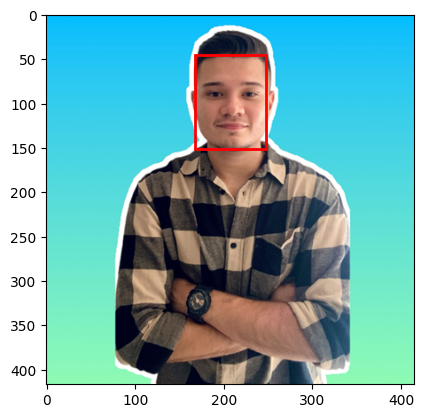

In [3]:
# Load and image
img = PIL.Image.open("../assets/me.png").convert(mode="RGB")

# Convert it to array
img = np.array(img)

# Create mtcc object
detector = MTCNN(min_face_size=30)

# Detect faces
resultados = detector.detect_faces(img)

# Plots
fig, ax = plt.subplots()
ax.imshow(img)
for resultado in resultados:
    x, y, w, h = resultado['box']
    rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
plt.show()


Let's use MTCNN tools from facenet_pytorch and crop the face 

In [4]:
del MTCNN
from facenet_pytorch import MTCNN

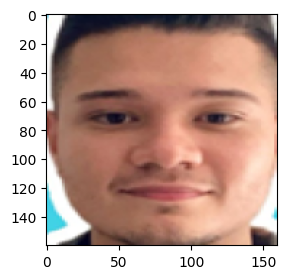

In [5]:
mtcnn = MTCNN(image_size=160, margin=5, min_face_size=35, post_process=False)
cropped_img = mtcnn(img).permute(1, 2, 0).int().numpy()
plt.figure(figsize=(3,3))
plt.imshow(cropped_img)
plt.show()

Let's compute a Embedding

In [6]:
mtcnn_detector = MTCNN(image_size=160, margin=5, min_face_size=35, post_process=True)
resnet = InceptionResnetV1(pretrained="vggface2", classify=False, device = device).eval()
cropped_img = mtcnn_detector(img).unsqueeze(0)
embedding = resnet(cropped_img)
print(f"Our embedding has a dimension of {embedding.shape[1]}")

Our embedding has a dimension of 512


Let's create our FaceDataset

In [12]:
ds = FaceDataset(root_dir="../data/unstructured/imgs")
dataloader = DataLoader(ds, batch_size=4, shuffle=True)

Plot some images

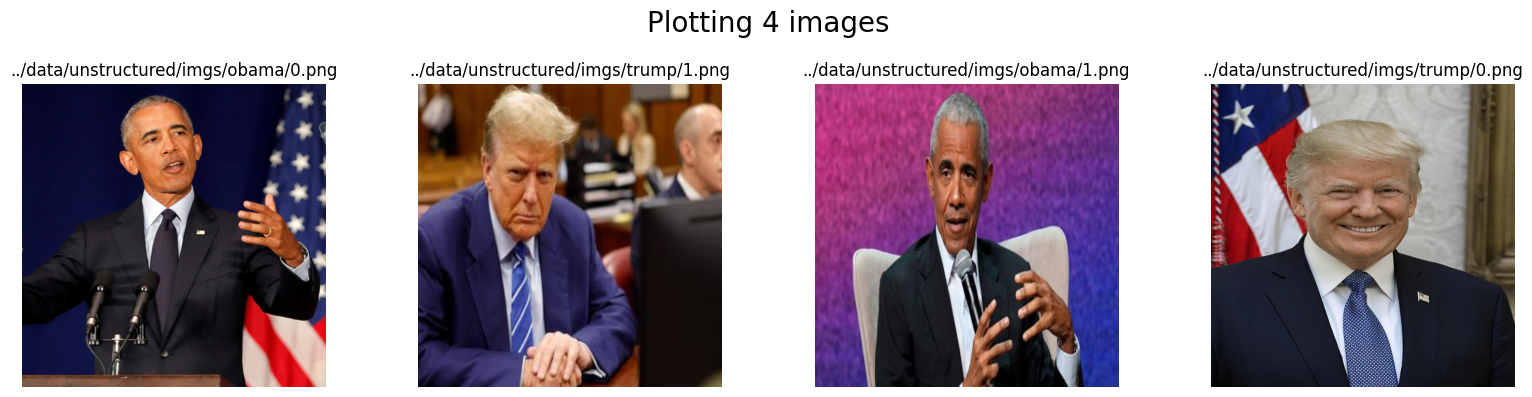

In [8]:
test_imgs, labels_imgs = next(iter(dataloader))
test_imgs = [np.array(img) for img in test_imgs]
plot_images_horizontal(test_imgs, labels_imgs)

Process the dataset by batch detecting faces and computing embeddings 

In [13]:
embeddings = []
used = []
with torch.no_grad():
    for run, (batch, idxs) in enumerate(dataloader):
        print (f"Batch # {run+1} of size {dataloader.batch_size}")
        to_use = []
        batch_images = []
        not_used = []
        for idx, img in enumerate (batch):
            detected_face, prob = mtcnn_detector(img, return_prob=True)
            if prob is not None:
                batch_images.append(detected_face.to(device))
                used.append(idxs[idx])
            else:
                not_used.append(idxs[idx])

        if len (batch_images) > 0:
            embedding = resnet(torch.stack(batch_images)).to("cpu")
            used.extend(to_use)
            embeddings.append(embedding)

            del batch_images, to_use, detected_face, embedding
            torch.cuda.empty_cache()

Batch # 1 of size 4s
Batch # 2 of size 4s


Persists embeddings and labels

In [20]:
data = [torch.cat(embeddings, dim=0), used]
torch.save(data, "../data/unstructured/imgs_embeddings/data.pt")

In [22]:
client = QdrantClient(host="localhost", port=6333)

In [43]:
my_collection = "face_embeddings2"
client.recreate_collection(
    collection_name=my_collection,
    vectors_config=models.VectorParams(size=512, distance=models.Distance.COSINE)
)

True

In [36]:
embeddings[0].shape

torch.Size([4, 512])

In [33]:
[{"path": path} for path in used]

[{'path': '../data/unstructured/imgs/trump/2.png'},
 {'path': '../data/unstructured/imgs/obama/1.png'},
 {'path': '../data/unstructured/imgs/trump/1.png'},
 {'path': '../data/unstructured/imgs/obama/0.png'},
 {'path': '../data/unstructured/imgs/obama/2.png'},
 {'path': '../data/unstructured/imgs/trump/0.png'}]

In [41]:
[{"path": path} for path in used][:2]

[{'path': '../data/unstructured/imgs/trump/2.png'},
 {'path': '../data/unstructured/imgs/obama/1.png'}]

In [66]:
client.upsert(
    collection_name=my_collection,
    points=models.Batch(
        ids=[i for i in range(len(used))],
        vectors=torch.cat(embeddings, dim=0).tolist(),
        payloads = [{"path": path[1:]} for path in used]
    )
)

UpdateResult(operation_id=1, status=<UpdateStatus.COMPLETED: 'completed'>)

In [49]:
import PIL.Image

test = PIL.Image.open("../assets/obama_test.png")
test = test.convert(mode="RGB")

In [67]:
detected_face, prob = mtcnn_detector(test, return_prob=True)
embedding = resnet(detected_face.unsqueeze(0))

In [68]:
client.search(
    collection_name=my_collection,
    query_vector=embedding.detach().cpu().numpy().tolist()[0],
    score_threshold=0.6,
    limit=10
)

[ScoredPoint(id=4, version=1, score=0.69455683, payload={'path': './data/unstructured/imgs/obama/2.png'}, vector=None, shard_key=None),
 ScoredPoint(id=3, version=1, score=0.6854315, payload={'path': './data/unstructured/imgs/obama/0.png'}, vector=None, shard_key=None),
 ScoredPoint(id=1, version=1, score=0.632252, payload={'path': './data/unstructured/imgs/obama/1.png'}, vector=None, shard_key=None)]

## Face similarity Search

In [69]:
from transformers import ViTImageProcessor, ViTModel
from PIL import Image
import requests

url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)

processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
inputs = processor(images=image, return_tensors="pt")

outputs = model(**inputs)
last_hidden_states = outputs.last_hidden_state

In [70]:
outputs = model(**inputs)
last_hidden_states = outputs.last_hidden_state

In [79]:
outputs.pooler_output.shape

torch.Size([1, 768])

In [163]:
from datasets import load_dataset, Image

dataset = load_dataset(path="../data/unstructured/animals", split="train")

In [164]:
def transforms(examples):
    examples["image"] = [image.convert("RGB") for image in examples["image"]]
    return examples

dataset = dataset.map(transforms, batched=True)

In [165]:
def preprocess_image(batch: dict):
    images = [image for image in batch["image"]]
    inputs = processor(images=images, return_tensors="pt")
    return inputs

dataset = dataset.map(preprocess_image, batched=True, batch_size=8)
    

In [182]:
a = torch.tensor(dataset[0]["pixel_values"])
b = torch.tensor(dataset[1]["pixel_values"])
torch.stack([a,b]).shape

torch.Size([2, 3, 224, 224])

In [189]:
def create_embeddings(batch: dict):
    pixel_values = torch.stack([torch.tensor(b) for b in batch["pixel_values"]])
    inputs = {"pixel_values": pixel_values}
    outputs = model(**inputs)
    last_hidden_states = outputs.pooler_output
    return {"pooler_output": last_hidden_states}

dataset = dataset.map(create_embeddings, batched=True, batch_size=8)

In [194]:
ds_pandas = dataset.to_pandas()